In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import RobustScaler 

import squarify

In [40]:
rfm_df= pd.read_csv('rfm_df.csv')
rfm_df.head(3)

,Unnamed: 0,Member_number,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
0,1388,2433,3,7,375.31,4,4,4,444,12,Best Customers
1,1159,2193,91,11,361.45,3,4,4,344,11,Big Spenders
2,772,1793,26,10,345.10,4,4,4,444,12,Best Customers


In [41]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3898 entries, 0 to 3897
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     3898 non-null   int64  
 1   Member_number  3898 non-null   int64  
 2   Recency        3898 non-null   int64  
 3   Frequency      3898 non-null   int64  
 4   Monetary       3898 non-null   float64
 5   R              3898 non-null   int64  
 6   F              3898 non-null   int64  
 7   M              3898 non-null   int64  
 8   RFM_Segment    3898 non-null   int64  
 9   RFM_Score      3898 non-null   int64  
 10  RFM_Level      3898 non-null   object 
dtypes: float64(1), int64(9), object(1)
memory usage: 335.1+ KB


## RFM + KMeans

In [42]:
df_now = rfm_df[['Recency','Frequency','Monetary']]
df_now.head()

,Recency,Frequency,Monetary
0,3,7,375.31
1,91,11,361.45
2,26,10,345.10
3,4,10,334.15
4,142,7,312.46


In [43]:
rfm_df['Log_Recency'] = np.log1p(rfm_df['Recency'])
rfm_df['Log_Frequency'] = np.log1p(rfm_df['Frequency'])
rfm_df['Log_Monetary'] = np.log1p(rfm_df['Monetary'])

scaler = RobustScaler()
rfm_df[['Scaled_Log_Recency', 'Scaled_Log_Frequency', 'Scaled_Log_Monetary']] = scaler.fit_transform(
    rfm_df[['Log_Recency', 'Log_Frequency', 'Log_Monetary']])

In [44]:
print(rfm_df.head())

   Unnamed: 0  Member_number  Recency  Frequency  Monetary  R  F  M  \
0        1388           2433        3          7    375.31  4  4  4   
1        1159           2193       91         11    361.45  3  4  4   
2         772           1793       26         10    345.10  4  4  4   
3        2225           3289        4         10    334.15  4  4  4   
4        1692           2743      142          7    312.46  2  4  4   

   RFM_Segment  RFM_Score       RFM_Level  Log_Recency  Log_Frequency  \
0          444         12  Best Customers     1.386294       2.079442   
1          344         11    Big Spenders     4.521789       2.484907   
2          444         12  Best Customers     3.295837       2.397895   
3          444         12  Best Customers     1.609438       2.397895   
4          244         10    Big Spenders     4.962845       2.079442   

   Log_Monetary  Scaled_Log_Recency  Scaled_Log_Frequency  Scaled_Log_Monetary  
0      5.930413           -2.262188              0.67

In [45]:
# Elbow Method để chọn k
X = rfm_df[['Scaled_Log_Recency', 'Scaled_Log_Frequency', 'Scaled_Log_Monetary']]

# Danh sách chứa SSE cho mỗi giá trị k
sse = {}

# Chạy KMeans cho các giá trị k từ 1 đến 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse[k] = kmeans.inertia_  

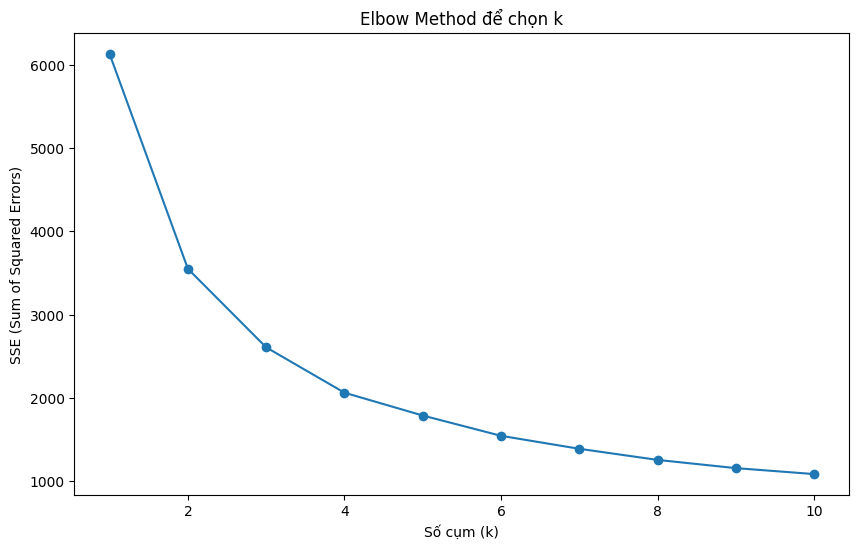

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel('Số cụm (k)')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('Elbow Method để chọn k')
plt.show()

In [47]:
from sklearn.cluster import KMeans

# Lấy các cột đã chuẩn hóa từ rfm_df
df_now_scaled = rfm_df[['Scaled_Log_Recency', 'Scaled_Log_Frequency', 'Scaled_Log_Monetary']]

# Thực hiện phân cụm với k = 4
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(df_now_scaled)

# Gán nhãn phân cụm vào cột 'Cluster' trong rfm_df
rfm_df['Cluster'] = kmeans.labels_

# Xem kết quả
print(rfm_df.head())


   Unnamed: 0  Member_number  Recency  Frequency  Monetary  R  F  M  \
0        1388           2433        3          7    375.31  4  4  4   
1        1159           2193       91         11    361.45  3  4  4   
2         772           1793       26         10    345.10  4  4  4   
3        2225           3289        4         10    334.15  4  4  4   
4        1692           2743      142          7    312.46  2  4  4   

   RFM_Segment  RFM_Score       RFM_Level  Log_Recency  Log_Frequency  \
0          444         12  Best Customers     1.386294       2.079442   
1          344         11    Big Spenders     4.521789       2.484907   
2          444         12  Best Customers     3.295837       2.397895   
3          444         12  Best Customers     1.609438       2.397895   
4          244         10    Big Spenders     4.962845       2.079442   

   Log_Monetary  Scaled_Log_Recency  Scaled_Log_Frequency  \
0      5.930413           -2.262188              0.678072   
1      5.892

In [48]:
# Tính trung bình và đếm số lượng cho từng cụm
rfm_agg2 = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(0)

In [49]:
# Đổi tên cột
rfm_agg2.columns = rfm_agg2.columns.droplevel()
rfm_agg2.columns = ['RecencyMean', 'FrequencyMean', 'MonetaryMean', 'Count']

In [50]:
# Tính phần trăm
rfm_agg2['Percent'] = round((rfm_agg2['Count'] / rfm_agg2.Count.sum()) * 100, 2)
rfm_agg2 = rfm_agg2.reset_index()

# Đổi kiểu dữ liệu cột Cluster
rfm_agg2['Cluster'] = 'Cluster ' + rfm_agg2['Cluster'].astype('str')
print(rfm_agg2)

     Cluster  RecencyMean  FrequencyMean  MonetaryMean  Count  Percent
0  Cluster 0         20.0            4.0          95.0    644    16.52
1  Cluster 1        248.0            3.0          61.0   1455    37.33
2  Cluster 2        131.0            6.0         139.0   1230    31.55
3  Cluster 3        344.0            2.0          19.0    569    14.60


In [51]:
import plotly.express as px

fig = px.scatter(rfm_agg2, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="Cluster",
                 hover_name="Cluster", size_max=100)
fig.show()

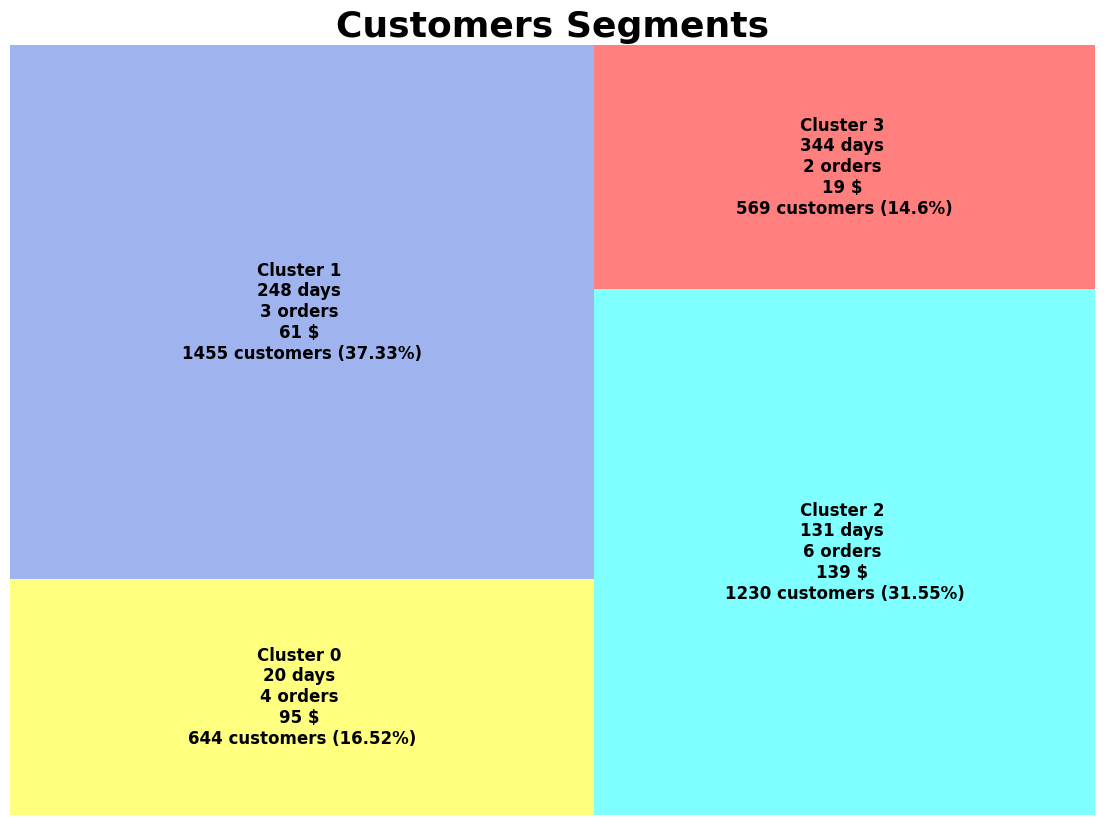

In [52]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)
colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple', 'Cluster5':'green', 'Cluster6':'gold'}
squarify.plot(sizes=rfm_agg2['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg2.iloc[i])
                      for i in range(0, len(rfm_agg2))], alpha=0.5 )
plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')
plt.show()

Cluster 0 (Màu vàng): Đây là nhóm khách hàng có chi tiêu cao nhất, nhưng số ngày không giao dịch (Recency) thấp. Họ có xu hướng mua hàng đều đặn.
Cluster 1 (Màu xanh lam): Nhóm khách hàng này có khoảng thời gian không giao dịch dài hơn và chi tiêu ở mức trung bình. Họ có thể là những khách hàng "mới" hoặc "khách hàng cũ" đang quay lại sau một thời gian dài.
Cluster 2 (Màu xanh lục): Đây là nhóm khách hàng có số ngày không giao dịch ít hơn và chi tiêu cao. Có thể họ là những khách hàng tiềm năng có thể tiếp tục mua sắm.
Cluster 3 (Màu đỏ): Nhóm khách hàng này có chi tiêu thấp và số ngày không giao dịch dài. Họ có thể là những khách hàng ít quan tâm hoặc ít mua hàng, cần chú ý cải thiện chiến lược giữ chân khách hàng.